In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Visualization

In [23]:
path = "/u/79/kurkil1/unix/work/molnet/data/SIN-AFM-FDBM/tmp"
images = [
    np.array(
        Image.open(
        os.path.join(path, f)
        )
    )
    for i, f in enumerate(os.listdir(path))
    if f.endswith('.png')
    and i < 15
]

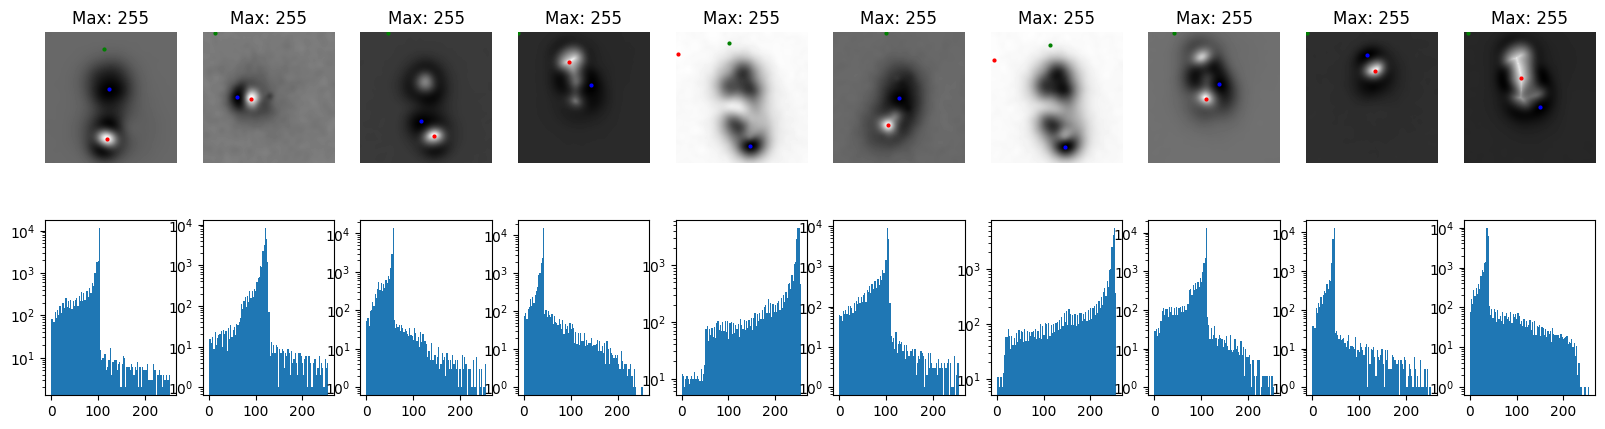

In [51]:
# plot 100 images
fig, (axs1, axs2) = plt.subplots(2, 10, figsize=(20, 5))
for i, (ax1, ax2) in enumerate(zip(axs1, axs2)):
    ax1.imshow(images[i], vmin=0, vmax=255, cmap='gray')

    # Find location of max value and mark it with a red dot
    max_val = np.max(images[i])
    max_idx = np.argmax(images[i])
    max_x = max_idx % images[i].shape[1]
    max_y = max_idx // images[i].shape[1]

    min_val = np.min(images[i])
    min_idx = np.argmin(images[i])
    min_x = min_idx % images[i].shape[1]
    min_y = min_idx // images[i].shape[1]

    median_val = np.median(images[i])
    median_idx = np.argmin(np.abs(images[i] - median_val))
    median_x = median_idx % images[i].shape[1]
    median_y = median_idx // images[i].shape[1]

    ax1.plot(max_x, max_y, 'ro', markersize=2)
    ax1.plot(min_x, min_y, 'bo', markersize=2)
    ax1.plot(median_x, median_y, 'go', markersize=2)

    ax1.set_title(f'Max: {max_val}')
    ax1.axis('off')

    # Plot histogram of pixel values
    ax2.hist(images[i].flatten(), bins=100)
    ax2.set_yscale('log')
    #ax2.set_xscale('log')

plt.show()

In [46]:
# for each image, print min and max, and data type
for i, img in enumerate(images):
    print(f"Image {i} min: {np.min(img)} max: {np.max(img)} dtype: {img.dtype}")

Image 0 min: 0 max: 255 dtype: uint8
Image 1 min: 0 max: 255 dtype: uint8
Image 2 min: 0 max: 255 dtype: uint8
Image 3 min: 0 max: 255 dtype: uint8
Image 4 min: 0 max: 255 dtype: uint8
Image 5 min: 0 max: 255 dtype: uint8
Image 6 min: 0 max: 255 dtype: uint8
Image 7 min: 0 max: 255 dtype: uint8
Image 8 min: 0 max: 255 dtype: uint8
Image 9 min: 0 max: 255 dtype: uint8
Image 10 min: 0 max: 255 dtype: uint8
Image 11 min: 0 max: 255 dtype: uint8
Image 12 min: 0 max: 255 dtype: uint8
Image 13 min: 0 max: 255 dtype: uint8


## wds datatype

In [2]:
import io
import re

import webdataset as wds

from typing import Dict, Any

In [59]:
def get_scan_window_from_comment(comment: str) -> np.ndarray:
    """
    Process the comment line in a .xyz file and extract the bounding box of the scan.
    The comment either has the format (QUAM dataset)

        ``Lattice="x0 x1 x2 y0 y1 y2 z0 z1 z2"``

    where the lattice is assumed to be orthogonal and origin at zero, or

        ``Scan window: [[x_start y_start z_start], [x_end y_end z_end]]``

    Arguments:
        comment: Comment to parse.

    Returns:
        The xyz coordinates of the opposite corners of the scan window in the form
            ``((x_start, y_start, z_start), (x_end, y_end, z_end))``
    """
    comment = comment.lower()
    match = re.match('.*lattice="((?:[+-]?(?:[0-9]*\.)?[0-9]+\s?){9})"', comment)
    if match:
        vectors = np.array([float(s) for s in match.group(1).split()])
        vectors = vectors.reshape((3, 3))
        sw = np.zeros((2, 3), dtype=np.float32)
        sw[1] = np.diag(vectors)
    elif match := re.match(
        r".*scan window: [\[(]{2}\s*((?:[+-]?(?:[0-9]*\.)?[0-9]+(?:e[-+]?[0-9]+)?,?\s*){3})[\])],\s*[\[(]\s*((?:[+-]?(?:[0-9]*\.)?[0-9]+(?:e[-+]?[0-9]+)?,?\s*){3})[\])]{2}.*",
        comment,
    ):
        start = np.array([float(s.strip(',')) for s in match.group(1).split()])
        end = np.array([float(s.strip(',')) for s in match.group(2).split()])
        sw = np.stack([start, end], axis=0)
    else:
        raise ValueError(f"Could not parse scan window in comment: `{comment}`")
    return sw

def decode_xyz(key, data):
    """
    Webdataset pipeline function for decoding xyz files.

    Arguments:
        key: Stream value key. If the key is ``'.xyz'``, then the data is decoded.
        data: Data to decode.

    Returns:
        Tuple (**xyz**, **scan_window**), where

        - **xyz** - Decoded atom coordinates and elements as an array where each row is of the form ``[x, y, z, element]``.
        - **scan_window** - The xyz coordinates of the opposite corners of the scan window in the form
          ``((x_start, y_start, z_start), (x_end, y_end, z_end))``

        If the stream key did not match, the tuple is ``(None, None)`` instead.
    """
    if key == ".xyz":
        data = io.BytesIO(data)
        atom_number = data.readline().decode("utf-8")
        comment = data.readline().decode("utf-8")
        sw = get_scan_window_from_comment(comment)
        xyz = []
        while line := data.readline().decode("utf-8"):
            e, x, y, z = line.strip().split()[:4]
            e = int(e)
            xyz.append([np.float32(x), np.float32(y), np.float32(z), e])
            print(e)
        return np.array(xyz).astype(np.float32), sw
    else:
        return None, None


In [ ]:
def batch_to_numpy(batch: Dict[str, Any]):
    images = []
    for k, v in batch.items():
        # If key ends in png, it is an image
        if k.endswith(".png"):
            images.append(v)
        # If key ends in .xyz, it is tuple (xyz, scan_window)
    xyz, sw = batch['xyz']

    # Keep only water hydrogen and oxygen atoms
    #xyz = xyz[xyz[:, 3] < 9]

    # Add column to xyz for charge (index 3) value 0
    charge = np.zeros((xyz.shape[0], 1), dtype=np.float32)
    xyz = np.concatenate([xyz[:, :-1], charge, xyz[:, [-1]]], axis=1)

    x = np.stack(images, axis=0)
    return x, xyz, sw


In [61]:
data_folder = "/u/79/kurkil1/unix/work/molnet/data/SIN-AFM-FDBM/"
urls = [
    os.path.join(data_folder, f)
    for f in os.listdir(data_folder)
    if f.endswith('.tar')
]

print(f"loaded {len(urls)} urls")

loaded 360 urls


In [62]:
ds = wds.WebDataset(urls)
#ds.append(wds.tariterators.tarfile_to_samples())
ds.append(wds.decode("pill", decode_xyz))
dl = wds.WebLoader(ds, collate_fn=batch_to_numpy, batch_size=None)

/u/79/kurkil1/unix/.venvs/tf-2.13/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [65]:
batch = next(iter(dl))

8
8
8
8
7
6
6
6
6
6
6
6
6
6
1
1
1
1
1
1
1


In [8]:
x, xyz, sw = batch

In [9]:
print(f"Images shape: {x.shape}, dtype: {x.dtype}")
print(f"xyz shape: {xyz.shape}, dtype: {xyz.dtype}")
print(f"scan window: {sw}, dtype: {sw.dtype}")

Images shape: (15, 160, 160), dtype: uint8
xyz shape: (21, 5), dtype: float32
scan window: [[10.80767407  7.43848054 22.12037387]
 [30.68267407 27.31348054 25.32037387]], dtype: float64


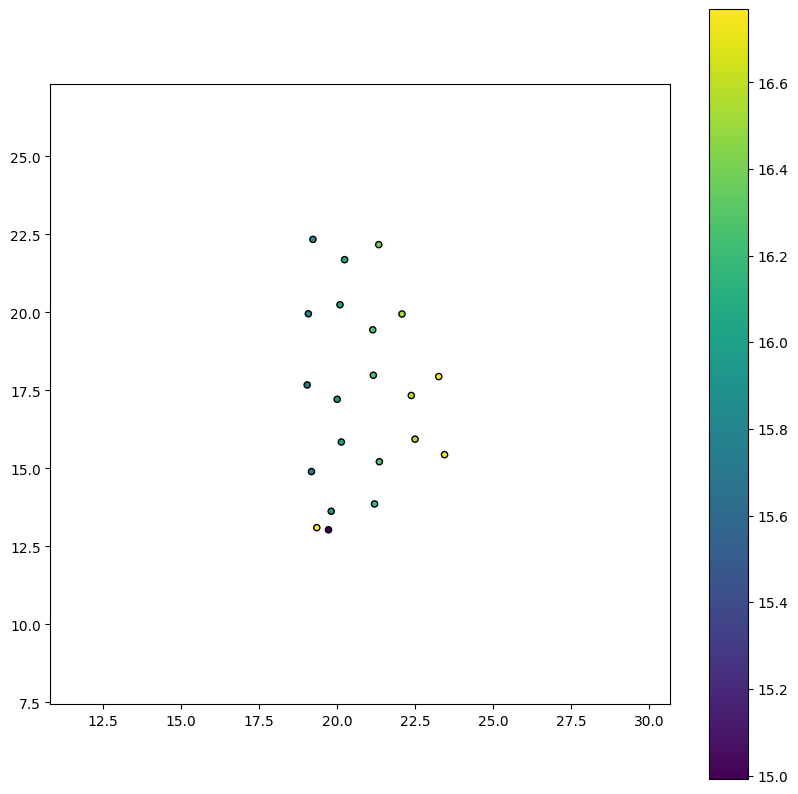

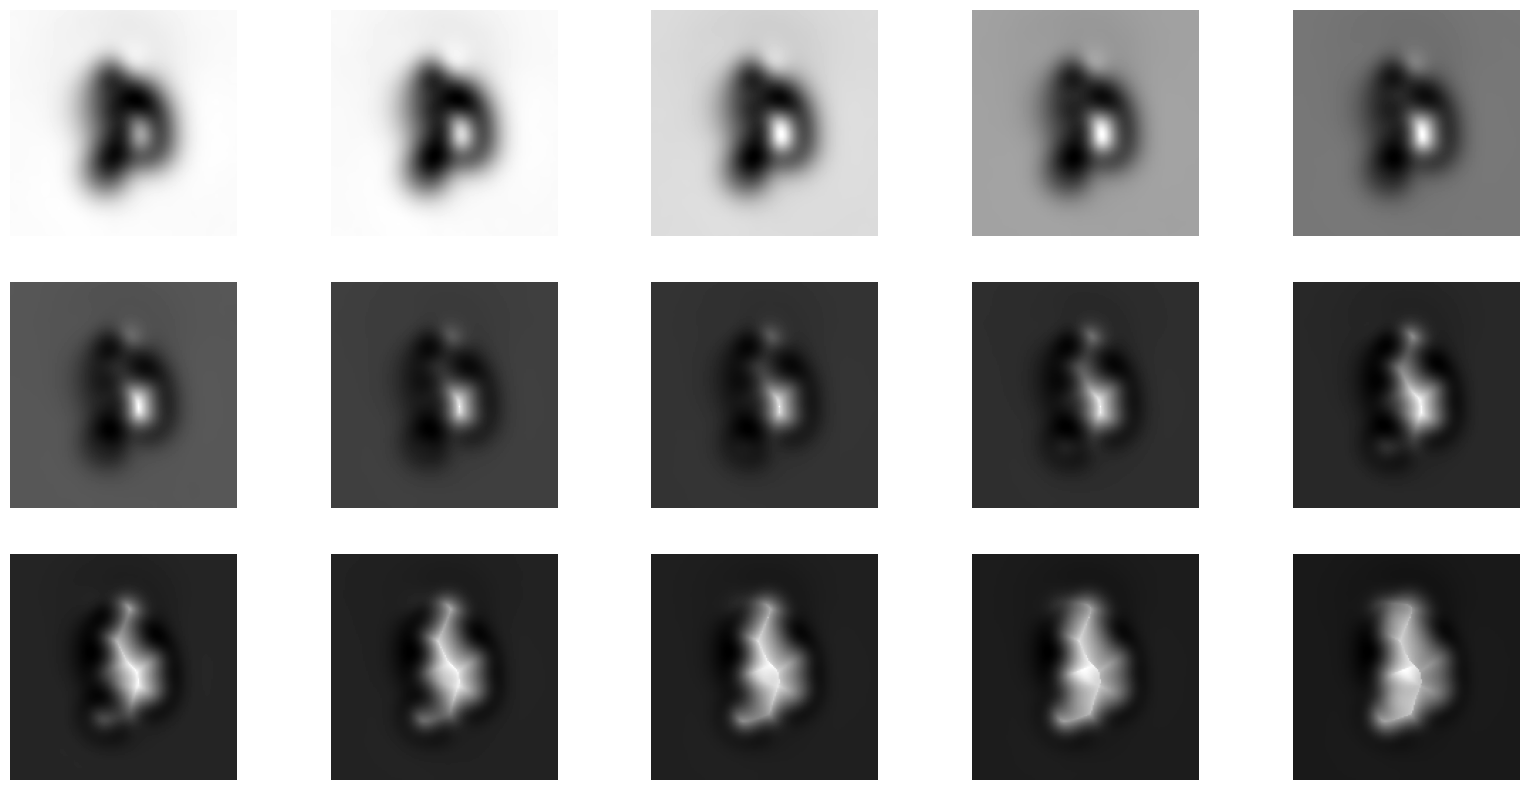

In [86]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(xyz[:, 0], xyz[:, 1], c=xyz[:, 2], cmap='viridis', edgecolors='k', s=20)
plt.xlim(sw[0, 0], sw[1, 0])
plt.ylim(sw[0, 1], sw[1, 1])
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x[i], vmin=0, vmax=255, cmap='gray')
    ax.axis('off')
plt.show()

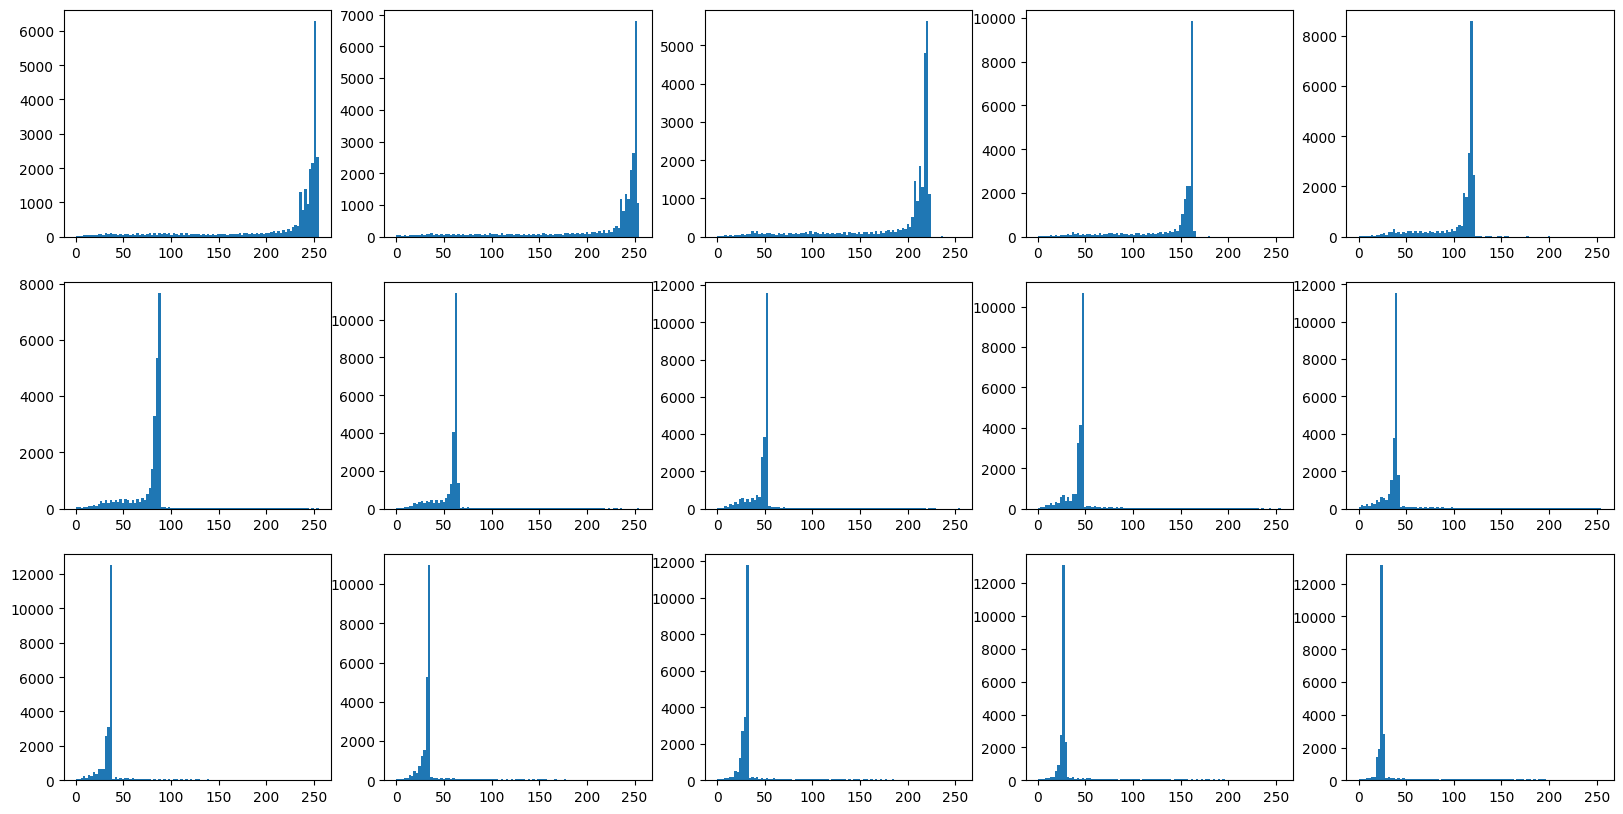

In [10]:
# Plot histogram of pixel values
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.hist(x[i].flatten(), bins=100)

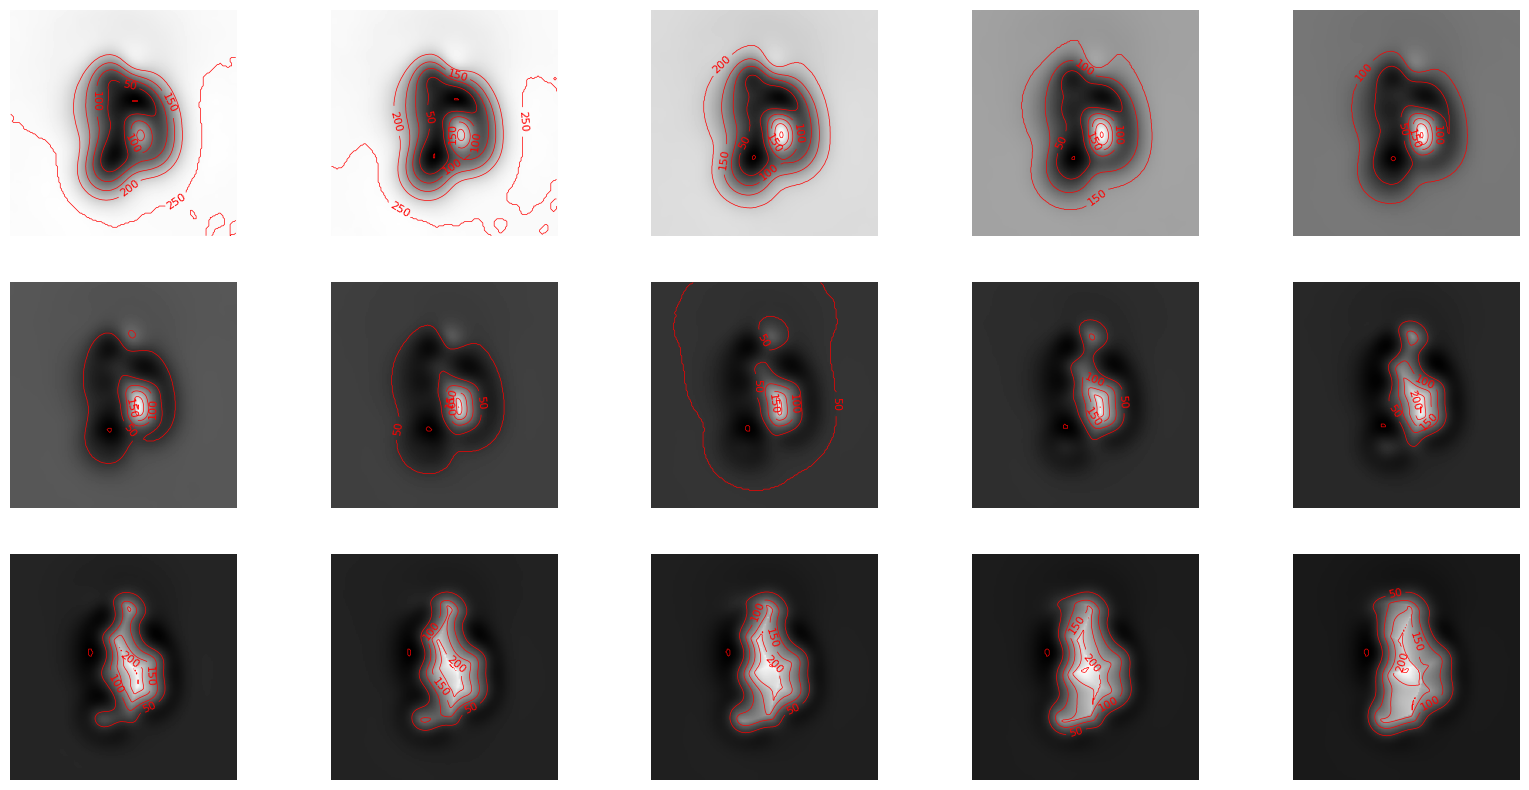

In [23]:
# Plot image with contour
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x[i], vmin=0, vmax=255, cmap='gray')
    cs = ax.contour(
        x[i],
        levels=[0, 50, 100, 150, 200, 250],
        colors='r',
        linewidths=0.5
    )
    ax.clabel(cs, inline=True, fontsize=8)
    ax.axis('off')

In [66]:
#dataloader = iter(dl)
for i, batch in enumerate(dl):
    x, xyz, sw = batch

    print(f"{i} -- Images shape: {x.shape}, dtype: {x.dtype}, xyz unique elements: {np.unique(xyz[:, -1])}")

8
8
8
8
7
6
6
6
6
6
6
6
6
6
1
1
1
1
1
1
1
0 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
1 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
2 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
3 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
4 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
5 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
6 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements: [1. 6. 7. 8.]
17
8
7
6
6
6
6
6
6
1
1
1
1
1
1
1
1
1
1
1
1
7 -- Images shape: (15, 160, 160), dtype: uint8, xyz unique elements:

KeyboardInterrupt: 

## Load npz files

In [46]:
import tarfile
import tqdm

In [57]:
path = "/u/79/kurkil1/unix/work/molnet/data/SIN-AFM-FDBM-np.tar"

# Check existence of file
if os.path.exists(path):
    print(f"File {path} already exists")

# Get N first samples
N = 100
with tarfile.open(path, 'r') as tar:
    files = [
        tar.next().name
        for _ in range(N)
    ]

files = [f for f in files if f.endswith('.npz')]

File /u/79/kurkil1/unix/work/molnet/data/SIN-AFM-FDBM-np.tar already exists


In [58]:
# shuffle files
np.random.shuffle(files)

In [59]:
# Sort files by number
files = sorted(files, key=lambda f: int(f.split('/')[-1].split("_")[-1].split('.')[0]))

In [67]:
print(f"Number of files: {len(files)}")
chunk_size = 12
# Repeat files so that len(files) is a multiple of chunk_size
n = len(files)

r = n % chunk_size
m = chunk_size - r
if r != 0:
    files = files + files[:m]

Number of files: 108


In [68]:
print(f"Number of files: {len(files)}")

Number of files: 108


In [69]:
# Divide files into chunks of size chunk_size
chunks = [
    files[i:i + chunk_size]
    for i in range(0, len(files), chunk_size)
]

print(f"Number of chunks: {len(chunks)}")
print(chunks)

Number of chunks: 9
[['./SIN-AFM-FDBM-temp/train_batch_000000.npz', './SIN-AFM-FDBM-temp/train_batch_000001.npz', './SIN-AFM-FDBM-temp/train_batch_000002.npz', './SIN-AFM-FDBM-temp/train_batch_000003.npz', './SIN-AFM-FDBM-temp/train_batch_000004.npz', './SIN-AFM-FDBM-temp/train_batch_000005.npz', './SIN-AFM-FDBM-temp/train_batch_000006.npz', './SIN-AFM-FDBM-temp/train_batch_000007.npz', './SIN-AFM-FDBM-temp/train_batch_000008.npz', './SIN-AFM-FDBM-temp/train_batch_000009.npz', './SIN-AFM-FDBM-temp/train_batch_000010.npz', './SIN-AFM-FDBM-temp/train_batch_000011.npz'], ['./SIN-AFM-FDBM-temp/train_batch_000012.npz', './SIN-AFM-FDBM-temp/train_batch_000013.npz', './SIN-AFM-FDBM-temp/train_batch_000014.npz', './SIN-AFM-FDBM-temp/train_batch_000015.npz', './SIN-AFM-FDBM-temp/train_batch_000016.npz', './SIN-AFM-FDBM-temp/train_batch_000017.npz', './SIN-AFM-FDBM-temp/train_batch_000018.npz', './SIN-AFM-FDBM-temp/train_batch_000019.npz', './SIN-AFM-FDBM-temp/train_batch_000020.npz', './SIN-AFM